In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
# from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, SpatialDropout1D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import confusion_matrix, classification_report

# **Data Load and Visualization**

In [2]:
directory = "dataset"
directory_list = os.listdir(directory)

filepath = []
label = []

for dir in directory_list:
    directories = os.listdir(directory + '/' + dir)
    for file in directories:
        filepath.append(directory + '/' + dir + '/' + file)
        label.append(dir)

filepath_df = pd.DataFrame(filepath, columns=['filepath'])
label_df = pd.DataFrame(label, columns=['label'])

df = pd.concat([filepath_df, label_df], axis=1)
df

,filepath,label
0,dataset/asthma/P10AsthmaIE_49.wav,asthma
1,dataset/asthma/P10AsthmaIU_46.wav,asthma
2,dataset/asthma/P10AsthmaIU_50.wav,asthma
3,dataset/asthma/P10AsthmaRL_47.wav,asthma
4,dataset/asthma/P10AsthmaRS_48.wav,asthma
...,...,...
1206,dataset/pneumonia/P9Pneumonia63O.wav,pneumonia
1207,dataset/pneumonia/P9Pneumonia67I.wav,pneumonia
1208,dataset/pneumonia/P9Pneumonia73J.wav,pneumonia
1209,dataset/pneumonia/P9Pneumonia74S.wav,pneumonia


In [3]:
def check_audio(filepath):
    try:
        data, sample_rate = librosa.load(filepath, duration=2.5, offset=0.6)
        if len(data) == 0:
            return False
        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

check_audio('dataset')

An error occurred: [Errno 13] Permission denied: 'dataset'


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15624\2693250556.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(filepath, duration=2.5, offset=0.6)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


False

In [4]:
df['good'] = df['filepath'].apply(check_audio)
df = df[df.good]
df = df.reset_index()
df = df.drop('good', axis=1)
df

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15624\2693250556.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(filepath, duration=2.5, offset=0.6)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


,index,filepath,label
0,0,dataset/asthma/P10AsthmaIE_49.wav,asthma
1,1,dataset/asthma/P10AsthmaIU_46.wav,asthma
2,2,dataset/asthma/P10AsthmaIU_50.wav,asthma
3,3,dataset/asthma/P10AsthmaRL_47.wav,asthma
4,4,dataset/asthma/P10AsthmaRS_48.wav,asthma
...,...,...,...
1204,1206,dataset/pneumonia/P9Pneumonia63O.wav,pneumonia
1205,1207,dataset/pneumonia/P9Pneumonia67I.wav,pneumonia
1206,1208,dataset/pneumonia/P9Pneumonia73J.wav,pneumonia
1207,1209,dataset/pneumonia/P9Pneumonia74S.wav,pneumonia


In [5]:
label_classes = ['Bronchial', 'asthma', 'copd', 'healthy', 'pneumonia']

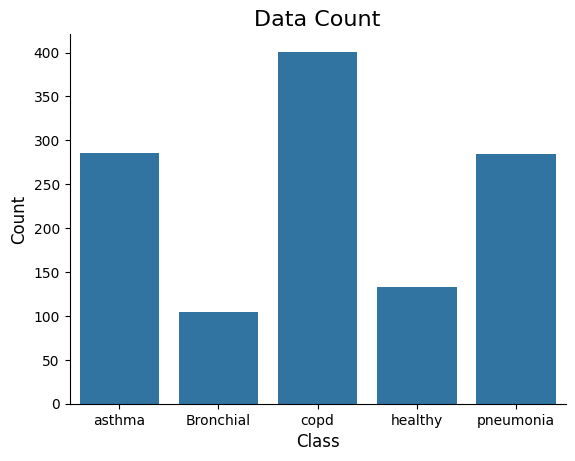

In [6]:
plt.title('Data Count', size=16)
sns.countplot(x='label', data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Class', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
label_counts = df['label'].value_counts()

print("Asthma count:", label_counts.get('asthma', 0))
print("Bronchial count:", label_counts.get('Bronchial', 0))
print("COPD count:", label_counts.get('copd', 0))
print("Healthy count:", label_counts.get('healthy', 0))
print("Pneumonia count:", label_counts.get('pneumonia', 0))


Asthma count: 286
Bronchial count: 104
COPD count: 401
Healthy count: 133
Pneumonia count: 285


# **Data Balancing**

In [8]:
# from sklearn.utils import resample

In [9]:
# target_size = 104
# balanced_data = []

# # Loop through each label, downsampling to the target size
# for label in df['label'].unique():
#     label_df = df[df['label'] == label]
#     if len(label_df) > target_size:
#         label_df = resample(label_df, replace=False, n_samples=target_size, random_state=42)
#     balanced_data.append(label_df)

# # Concatenate all resampled dataframes
# balanced_df = pd.concat(balanced_data).reset_index(drop=True)
# balanced_df

In [10]:
# plt.title('Data Count', size=16)
# sns.countplot(x='label', data=balanced_df)
# plt.ylabel('Count', size=12)
# plt.xlabel('Class', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

# **Feature Extraction**

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    return result

def get_aug_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.array(res2)
    
    # data with stretching and pitching
    stretch_data = stretch(data)
    data_stretch_pitch = pitch(stretch_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [12]:
def get_df_features(dataframe, augmentation=False):
    X, Y = [], []
    processed = 0
    total = len(dataframe.filepath)
    for filepath, label in zip(dataframe.filepath, dataframe.label):
        if augmentation:
            feature = get_aug_features(filepath)
            for aug in feature:
                X.append(aug)
                Y.append(label)
        else:
            feature = get_features(filepath)
            X.append(feature)
            Y.append(label)
        processed += 1
        print('Processed:', processed, '/', total, end="\r")
    return X, Y

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=49, shuffle=True)
df_train.shape, df_test.shape

((967, 3), (242, 3))

In [14]:
x_train, y_train = get_df_features(df_train)
print('Train data processed')

x_train_aug, y_train_aug = get_df_features(df_train, augmentation=True)
print('Train data augmentation processed')
x_train.extend(x_train_aug)
y_train.extend(y_train_aug)

x_test, y_test = get_df_features(df_test)
print('Test data processed')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1235
  warnings.warn(


Train data processed


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1544
  warnings.warn(


Train data augmentation processed
Test data processed2


In [15]:
features_train = pd.DataFrame(x_train)
features_train['label'] = y_train
# features_train.to_csv('features_train.csv', index=False)
# features_train

In [16]:
features_test = pd.DataFrame(x_test)
features_test['label'] = y_test
# features_test.to_csv('features_test.csv', index=False)
# features_test

# **Neural Network Setup**

In [17]:
x_train = features_train.iloc[: ,:-1].values
y_train = features_train['label'].values

x_test = features_test.iloc[: ,:-1].values
y_test = features_test['label'].values

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162), (2901,), (242, 162), (242,))

In [18]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()

encoder = OneHotEncoder()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162), (2901, 5), (242, 162), (242, 5))

In [19]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162, 1), (2901, 5), (242, 162, 1), (242, 5))

In [20]:
input_shape = (x_train.shape[1], 1)
inputs = Input(shape=input_shape)

x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(len(label_classes), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 162, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 162, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 81, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,133 (2.14 MB)

 Trainable params: 558,661 (2.13 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [21]:
start_lr = 0.000001
min_lr = 0.000001
max_lr = 0.0001
rampup_epochs = 9
sustain_epochs = 5
exp_decay = 0.9

def schedule(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr) / rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_scheduler = LearningRateScheduler(schedule, verbose=False)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, start_from_epoch=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=1e-3, factor=0.4, verbose=False, patience=2, min_lr=1e-6)

# **Neural Network Fit**

In [22]:
epochs = 100
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.2115 - loss: 2.0727 - val_accuracy: 0.2025 - val_loss: 1.8003 - learning_rate: 1.0000e-06
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.2839 - loss: 1.8132 - val_accuracy: 0.3099 - val_loss: 1.6284 - learning_rate: 1.2000e-05
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.3864 - loss: 1.5206 - val_accuracy: 0.3595 - val_loss: 1.5174 - learning_rate: 2.3000e-05
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.4689 - loss: 1.3952 - val_accuracy: 0.4545 - val_loss: 1.2952 - learning_rate: 3.4000e-05
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.5255 - loss: 1.2986 - val_accuracy: 0.4669 - val_loss: 1.3851 - learning_rate: 4.5000e-05
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5200 - loss: 1.2698 - val_accuracy: 0.5289 - val_loss: 1.1934 - learning_rate: 5.6000e-05
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accurac

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8500 - loss: 0.4807
Accuracy on test data : 83.05785059928894 %


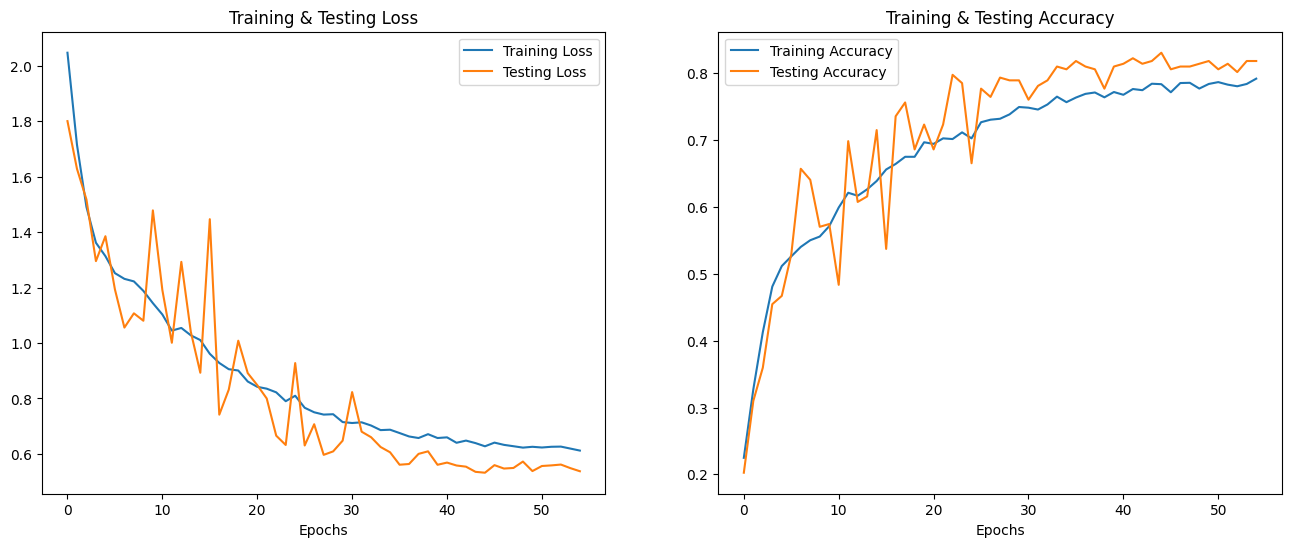

In [23]:
print("Accuracy on test data :" , model.evaluate(x_test,y_test)[1]*100 , "%")

num_epochs = len(history.history['loss'])
epoch = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(16,6)
ax[0].plot(epoch , train_loss , label = 'Training Loss')
ax[0].plot(epoch , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epoch , train_acc , label = 'Training Accuracy')
ax[1].plot(epoch , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [24]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test)

print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
              precision    recall  f1-score   support

   Bronchial       0.95      0.78      0.86        27
      asthma       0.78      0.93      0.85        58
        copd       0.89      0.82      0.86        80
     healthy       0.75      0.60      0.67        20
   pneumonia       0.79      0.84      0.81        57

    accuracy                           0.83       242
   macro avg       0.83      0.80      0.81       242
weighted avg       0.84      0.83      0.83       242



In [25]:
predictions = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
predictions['Predicted Labels'] = y_pred.flatten()
predictions['Actual Labels'] = y_true.flatten()

predictions.head(10)

,Predicted Labels,Actual Labels
0,copd,copd
1,pneumonia,pneumonia
2,pneumonia,pneumonia
3,pneumonia,pneumonia
4,copd,copd
5,pneumonia,pneumonia
6,Bronchial,Bronchial
7,healthy,healthy
8,Bronchial,Bronchial
9,copd,copd


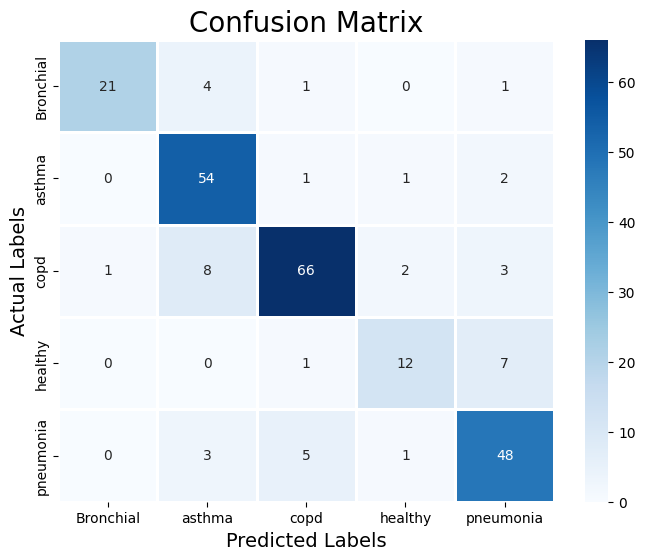

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
model.save('modelv3.keras')